In [1]:
import os
import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np
import itertools
import datetime
import glob
from shapely.geometry import GeometryCollection, Point, LineString
from lotek.conversion import shp2mask
from lotek.gps import calc_ta, calc_dist
from rasterio.enums import MergeAlg
from tqdm.notebook import tqdm
import re
import pyproj
import math
from sklearn.neighbors import BallTree

In [2]:
"""
Setup a cluster for parallel processing
"""
from distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=5, threads_per_worker=2)
client = Client(cluster)

In [3]:
"""
Setup for calculating bearing of steps
"""
geodesic = pyproj.Geod(ellps='WGS84')
utm_13N = pyproj.Proj(32613)

In [4]:
"""
Define I/O
"""

# Inputs
# path to main directories
inDIR_long = 'T:/5-CattleCollars/3-Projects/CARM_PairedComps/Paired Comps Long/'
inDIR_short = 'T:/5-CattleCollars/3-Projects/CARM_PairedComps/Paired Comps Short/'
inDIR_add = 'T:/5-CattleCollars/3-Projects/CARM_PairedComps/Paired Comps 4_5/'

# path to 1 m vegetation raster as grid template
veg_f = 'G:/neon_v18/neon_class_2017_v18.tif'

# path to 30 m raster as grid template
tif_30m_f = 'C:/SPK_local/data/rasters/Masks/CPER_dist_to_fence_2017.tif'

# path to shapefile with pasture boundaries
cper_f = "C:/SPK_local/data/vectors/Pasture_Boundaries/Shapefiles/cper_pastures_2017_clip.shp"

# create dictionary of paths to static co-variates
static_covariates = {
    'TPC': {
        'path': 'C:/SPK_local/data/rasters/DEM/TopoClass25m.tif'},
    'dFence': {
        'path': 'C:/SPK_local/data/rasters/Masks/CPER_dist_to_fence_2017.tif'},
    'dTank': {
        'path': 'C:/SPK_local/data/rasters/Masks/CPER_dist_to_tank_2017.tif'}
}

# path to shapefile containing stock tanks for 10 m distance raster
cper_tanks_f = 'C:/SPK_local/data/vectors/CPER_features/Stock_Tank_V1.shp'

# path to shapefile containing pasture corners
corners_f = 'C:/SPK_local/data/vectors/CPER_features/CPER_pasture_corners.shp'

# Outputs
# path to output directory
outDIR = 'C:/SPK_local/for_others/Augustine_lotek/paired_comps/'

In [5]:
# create dictionary to remap topgoraphic position class (TPC) values to strings
TPC_dict = {
    1.0: 'Lowlands', 2.0: 'Lowlands', 3.0: 'Lowlands',
    4.0: 'Other',
    5.0: 'Flat Plains',
    6.0: 'Open Slopes', 
    7.0: 'Other', 
    8.0: 'Highlands', 9.0: 'Highlands', 10.0: 'Highlands'
}

In [6]:
def make_steps(x):
    line_step = LineString([Point(x['UTM_X_lag1'], x['UTM_Y_lag1']),
                 Point(x['UTM_X'], x['UTM_Y'])])
    return line_step


def graze_intensity(x):
    if x['steplength'] == 0 or x['cell_ct'] == 0:
        return 60.0*x['Fix_Duration']
    else:
        gi = (60.0*x['Fix_Duration'])/x['cell_ct']
    if gi > 300:
        return 60.0*x['Fix_Duration']
    else:
        return gi

In [7]:
"""
Convert gridded covariates to xarray datasets
"""
for i in static_covariates:
    print(i)
    xr_tmp = xr.open_rasterio(static_covariates[i]['path']).squeeze('band')
    if i == 'TPC':
        xr_tmp = xr_tmp.astype('int')
    static_covariates[i]['data'] = xr_tmp

TPC
dFence
dTank


In [8]:
"""
Load corner and stock tank shapefiles to get distance for each pasture
"""
# read in shapefile of stock tanks
gdf_tanks = gpd.read_file(cper_tanks_f)

# read in shapefile of corners
gdf_corners = gpd.read_file(corners_f)

In [9]:
"""
Read in data and pre-format
"""
# get lists of gps data files
fLIST_long = glob.glob(inDIR_long + '*.csv')
fLIST_short = glob.glob(inDIR_short + '*.csv')
fLIST_add = glob.glob(inDIR_add + '*.csv')
#fLIST_all = fLIST_long + fLIST_short
fLIST_all = fLIST_add

# read in CPER pasture shapefile
df_cper = gpd.read_file(cper_f)

# dissolve by pasture to make sure each pasture is a single polygon
df_cper = df_cper.dissolve(by='Past_Name_').reset_index().rename(columns={'Past_Name_': 'Pasture'})

# convert pasture polygons to an xarray (1 m gridded raster) object with pasture name as value
cper_info = df_cper[['Pasture', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
past_dict = {row.id+1: row.Pasture for _, row in cper_info.iterrows()}
past_dict[0] = 'UNK'
past_mask_shp = [(row.geometry, row.id+1) for _, row in cper_info.iterrows()]

In [10]:
"""
Create 1 m and 30 m raster template for subsequent analysis
"""
# read in 1 m vegetation community raster as template and create pasture mask at 1 m
xr_veg = xr.open_rasterio(veg_f).squeeze('band')
past_mask_1m = shp2mask(shp=past_mask_shp, xr_object=xr_veg)
past_mask_1m.values = np.array([past_dict[i] for i in past_mask_1m.values.flatten()]).reshape(past_mask_1m.shape)

# read in 30 m template and create pasture mask at 30 m
xr_30m = xr.open_rasterio(tif_30m_f).squeeze().reset_coords(drop=True)
past_mask_30m = shp2mask(shp=past_mask_shp, xr_object=xr_30m)
past_mask_30m.values = np.array([past_dict[i] for i in past_mask_30m.values.flatten()]).reshape(past_mask_30m.shape)

In [11]:
"""
Loop through final pastures and weeks to extract final dataset 
of grazing time per cell for a given pasture, steer and time period
"""

# create function for splitting line into segments
def segments(curve):
    return list(map(LineString, zip(curve.coords[:-1], curve.coords[1:])))

# loop through week and pasture and steer to create each dataset
for gps_f in tqdm(fLIST_all):
    try:
        df_gps = pd.read_csv(gps_f, engine='python', parse_dates=['Date_Time'])
    except ValueError:
        try:
            df_gps = pd.read_csv(gps_f, engine='python', parse_dates=['Date_Time_Fix'])
            df_gps['Date_Time'] = df_gps['Date_Time_Fix']
        except ValueError:
            try:
                df_gps = pd.read_csv(gps_f, engine='python', parse_dates=['Fix_DateTime'])
                df_gps['Date_Time'] = df_gps['Fix_DateTime']
            except ValueError:
                print('Datetime column incorrectly named. Check .csv file.')

    df_gps['Fix_Duration'] = df_gps.groupby(['Steer_ID', 'SliceDay']).apply(
    lambda x: (x['Date_Time'] - x['Date_Time'].shift(1)).dt.seconds/60.0).reset_index()['Date_Time']

    # calculate the turning angle and distance at each fix for each day and each steer
    df_gps['steplength'] = np.nan
    df_gps['turnangle'] = np.nan
    for group in tqdm(df_gps.groupby(['Steer_ID', 'SliceDay'])):
        group[1]['UTM_X_lag1'] = group[1]['UTM_X'].shift(1)
        group[1]['UTM_Y_lag1'] = group[1]['UTM_Y'].shift(1)
        group[1]['UTM_X_lead1'] = group[1]['UTM_X'].shift(-1)
        group[1]['UTM_Y_lead1'] = group[1]['UTM_Y'].shift(-1)
        a_list = list(group[1][['UTM_X_lag1', 'UTM_Y_lag1']].values)
        b_list = list(group[1][['UTM_X', 'UTM_Y']].values)
        c_list = list(group[1][['UTM_X_lead1', 'UTM_Y_lead1']].values)
        dist_mask = ~(np.any(np.isnan(a_list), axis=1) |  np.any(np.isnan(b_list), axis=1))
        sl_tmp = np.ones_like(dist_mask) * np.nan
        sl_tmp[dist_mask] = calc_dist(np.array(list(map(tuple, a_list)))[dist_mask], 
                                      np.array(list(map(tuple, b_list)))[dist_mask]).squeeze()
        df_gps.loc[(df_gps['Steer_ID'] == group[0][0]) & (df_gps['SliceDay'] == group[0][1]),
                   'steplength'] = sl_tmp
        df_gps.loc[(df_gps['Steer_ID'] == group[0][0]) & (df_gps['SliceDay'] == group[0][1]),
                   'turnangle'] = calc_ta(a_list, b_list, c_list)
        df_gps.loc[(df_gps['Steer_ID'] == group[0][0]) & (df_gps['SliceDay'] == group[0][1]),
                   'UTM_X_lag1'] = group[1]['UTM_X_lag1']
        df_gps.loc[(df_gps['Steer_ID'] == group[0][0]) & (df_gps['SliceDay'] == group[0][1]),
                   'UTM_Y_lag1'] = group[1]['UTM_Y_lag1']


    # Calculate movement rate from distance and timestamp
    df_gps['moverate'] = df_gps['steplength'] / df_gps['Fix_Duration']

    geometry_steps = df_gps[(df_gps.GrazingAct == 1) &
                            df_gps.moverate.notnull()].apply(make_steps, axis=1)

    gdf_steps = gpd.GeoDataFrame(df_gps[(df_gps.GrazingAct == 1) &
                                        df_gps.moverate.notnull()],
                                 geometry=geometry_steps)

    steps_coords = gdf_steps.apply(lambda x: utm_13N(x.geometry.coords.xy[0],
                                                     x.geometry.coords.xy[1], 
                                                     inverse=True), axis=1)

    fwd_azimuth_all = steps_coords.apply(lambda x: geodesic.inv(x[0][0],
                                                                x[1][0],
                                                                x[0][1],
                                                                x[1][1])[0])

    gdf_steps['bearing'] = fwd_azimuth_all
    gdf_steps['diff45'] = abs(round(abs(fwd_azimuth_all/90)) - abs(fwd_azimuth_all/90)) * 2.0
    gdf_steps['cell_ct'] = gdf_steps.apply(lambda x: 1 + np.round(x.steplength*math.cos(math.radians(45*x.diff45))), 
                                           axis=1)


    secs_m = gdf_steps.apply(graze_intensity, axis=1)

    # add movement rate to geodata frame
    gdf_steps['secs_m'] = secs_m.values

    past = df_gps['Pasture'].unique()[0]
    xr_temp_1m = past_mask_1m.where(past_mask_1m == past, drop=True)
    xr_temp_1m = xr_temp_1m.assign_attrs({'transform': (1.0, 0.0, xr_temp_1m.x.min().values - 0.5, 
                                               0.0, -1.0, xr_temp_1m.y.max().values + 0.5)})
    steps_info = gdf_steps[['secs_m', 'geometry']].reset_index(drop=True).reset_index().rename(
        columns={'index': 'id'})
    steps_shp = [(row.geometry, row.secs_m) for _, row in steps_info.iterrows()]
    xr_steps_1m = shp2mask(shp=steps_shp, xr_object=xr_temp_1m, dtype='float32',
                        merge_alg=MergeAlg('ADD'), all_touched=False)#.stack(z=['x', 'y'])

    xr_steps_10m = xr_steps_1m.coarsen(dim=dict(x=10, y=10), boundary='trim').sum()
    past_mask_10m = (past_mask_1m == past).coarsen(dim=dict(x=10, y=10), 
                                                   boundary='trim').sum()
    past_mask_10m = past_mask_10m.where(past_mask_10m > 80, drop=True)
    xr_steps_10m = xr_steps_10m.reindex_like(past_mask_10m, method='nearest')
    xr_steps_10m = xr_steps_10m.where(past_mask_10m > 80, drop=True)

    df_tmp = pd.DataFrame({
        'Pasture': past,
        'UTM_X': [i[0] for i in xr_steps_10m.stack(z=['x', 'y'])['z'].values],
        'UTM_Y': [i[1] for i in xr_steps_10m.stack(z=['x', 'y'])['z'].values],
        'grazing_secs': xr_steps_10m.stack(z=['x', 'y']).values
    })

    
    # get distance to stock tanks
    x_coords_tanks = [i[0][0] for i in gdf_tanks.apply(lambda x: x.geometry.coords.xy, axis=1)]
    y_coords_tanks = [i[1][0] for i in gdf_tanks.apply(lambda x: x.geometry.coords.xy, axis=1)]

    # Create a BallTree object
    # borrowed from: https://stackoverflow.com/questions/58893719/find-nearest-point-in-other-dataframe-with-a-lot-of-data
    tree_tanks = BallTree(np.array(list(zip(x_coords_tanks, y_coords_tanks))),
                          leaf_size=2)

    #Query the BallTree on all GPS coordinates from collars deployed in the pasture to find the distance
    # to the nearest stock tank and its id
    dist_tmp_tanks, id_tmp_tanks= tree_tanks.query(
        df_tmp.loc[:, ['UTM_X', 'UTM_Y']].values, # The input array for the query
        k=1, # The number of nearest neighbors
    )
    df_tmp.loc[:, 'dTank'] = dist_tmp_tanks
    
    
    # get distance to pasture corners
    gdf_corners_p = gdf_corners[gdf_corners['Pasture'] == past]
    x_coords_corners = [i[0][0] for i in gdf_corners_p.apply(lambda x: x.geometry.coords.xy, axis=1)]
    y_coords_corners = [i[1][0] for i in gdf_corners_p.apply(lambda x: x.geometry.coords.xy, axis=1)]

    # Create a BallTree object
    # borrowed from: https://stackoverflow.com/questions/58893719/find-nearest-point-in-other-dataframe-with-a-lot-of-data
    tree_corners = BallTree(np.array(list(zip(x_coords_corners, y_coords_corners))),
                            leaf_size=2)

    #Query the BallTree on all GPS coordinates from collars deployed in the pasture to find the distance
    # to the nearest pixel within the pasture and its id
    dist_tmp_corners, id_tmp_corners= tree_corners.query(
        df_tmp.loc[:, ['UTM_X', 'UTM_Y']].values, # The input array for the query
        k=1, # The number of nearest neighbors
    )
    df_tmp.loc[:, 'dCorner'] = dist_tmp_corners
    
    # remove null values
    df_tmp.loc[df_tmp['grazing_secs'] > 3.40e38, 'grazing_secs'] = np.nan
    df_tmp = df_tmp[df_tmp['grazing_secs'].notnull()]
    
    # print out sanity check:
    print('Gridded graze time: ' + str(round(df_tmp['grazing_secs'].sum()/60/60/24, 2)))
    print('GPS graze time: ' + str(round(gdf_steps['Fix_Duration'].sum()/60/24, 2)))
    display(df_tmp['grazing_secs'].describe())
    
    df_tmp.to_csv(outDIR + re.sub('.csv', '_graze_intens_grid.csv', gps_f.split('\\')[-1]), index=False)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

C:\Users\sean.kearney\Github\lotek_processing\lotek\gps.py:23: RuntimeWarning: invalid value encountered in double_scalars
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))


Gridded graze time: 46.88
GPS graze time: 48.07


count    13073.000000
mean       309.798889
std        373.643707
min          0.000000
25%         95.454552
50%        222.286499
75%        435.453369
max      18451.480469
Name: grazing_secs, dtype: float64

  0%|          | 0/124 [00:00<?, ?it/s]

C:\Users\sean.kearney\Github\lotek_processing\lotek\gps.py:23: RuntimeWarning: invalid value encountered in double_scalars
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))


Gridded graze time: 41.6
GPS graze time: 44.1


count    12428.000000
mean       289.213715
std        498.796906
min          0.000000
25%         75.589113
50%        172.115974
75%        349.831680
max      24149.990234
Name: grazing_secs, dtype: float64

In [13]:
gps_f

'T:/5-CattleCollars/3-Projects/CARM_PairedComps/Paired Comps Additional\\CARM2015_Rotn4_6steer_227d.csv'

In [27]:
#failed file
[idx for (idx, i) in enumerate(fLIST_all) if i == gps_f]

[94]

In [14]:
test_f = 'T:/5-CattleCollars/3-Projects/CARM_PairedComps/Paired Comps Long\\TRM2016_Rotn2_2steer_193d.csv'

In [17]:
gps_f = test_f
try:
    df_gps = pd.read_csv(gps_f, engine='python', parse_dates=['Date_Time'])
except ValueError:
    df_gps = pd.read_csv(gps_f, engine='python', parse_dates=['Date_Time_Fix'])
    df_gps['Date_Time'] = df_gps['Date_Time_Fix']

df_gps['Fix_Duration'] = df_gps.groupby(['Steer_ID', 'SliceDay']).apply(
lambda x: (x['Date_Time'] - x['Date_Time'].shift(1)).dt.seconds/60.0).reset_index()['Date_Time']

# calculate the turning angle and distance at each fix for each day and each steer
df_gps['steplength'] = np.nan
df_gps['turnangle'] = np.nan
for group in tqdm(df_gps.groupby(['Steer_ID', 'SliceDay'])):
    group[1]['UTM_X_lag1'] = group[1]['UTM_X'].shift(1)
    group[1]['UTM_Y_lag1'] = group[1]['UTM_Y'].shift(1)
    group[1]['UTM_X_lead1'] = group[1]['UTM_X'].shift(-1)
    group[1]['UTM_Y_lead1'] = group[1]['UTM_Y'].shift(-1)
    a_list = list(group[1][['UTM_X_lag1', 'UTM_Y_lag1']].values)
    b_list = list(group[1][['UTM_X', 'UTM_Y']].values)
    c_list = list(group[1][['UTM_X_lead1', 'UTM_Y_lead1']].values)
    dist_mask = ~(np.any(np.isnan(a_list), axis=1) |  np.any(np.isnan(b_list), axis=1))
    sl_tmp = np.ones_like(dist_mask) * np.nan
    sl_tmp[dist_mask] = calc_dist(np.array(list(map(tuple, a_list)))[dist_mask], 
                                  np.array(list(map(tuple, b_list)))[dist_mask]).squeeze()
    df_gps.loc[(df_gps['Steer_ID'] == group[0][0]) & (df_gps['SliceDay'] == group[0][1]),
               'steplength'] = sl_tmp
    df_gps.loc[(df_gps['Steer_ID'] == group[0][0]) & (df_gps['SliceDay'] == group[0][1]),
               'turnangle'] = calc_ta(a_list, b_list, c_list)
    df_gps.loc[(df_gps['Steer_ID'] == group[0][0]) & (df_gps['SliceDay'] == group[0][1]),
               'UTM_X_lag1'] = group[1]['UTM_X_lag1']
    df_gps.loc[(df_gps['Steer_ID'] == group[0][0]) & (df_gps['SliceDay'] == group[0][1]),
               'UTM_Y_lag1'] = group[1]['UTM_Y_lag1']
    

# Calculate movement rate from distance and timestamp
df_gps['moverate'] = df_gps['steplength'] / df_gps['Fix_Duration']

geometry_steps = df_gps[(df_gps.GrazingAct == 1) &
                        df_gps.moverate.notnull()].apply(make_steps, axis=1)

gdf_steps = gpd.GeoDataFrame(df_gps[(df_gps.GrazingAct == 1) &
                                    df_gps.moverate.notnull()],
                             geometry=geometry_steps)

steps_coords = gdf_steps.apply(lambda x: utm_13N(x.geometry.coords.xy[0],
                                                 x.geometry.coords.xy[1], 
                                                 inverse=True), axis=1)

fwd_azimuth_all = steps_coords.apply(lambda x: geodesic.inv(x[0][0],
                                                            x[1][0],
                                                            x[0][1],
                                                            x[1][1])[0])

gdf_steps['bearing'] = fwd_azimuth_all
gdf_steps['diff45'] = abs(round(abs(fwd_azimuth_all/90)) - abs(fwd_azimuth_all/90)) * 2.0
gdf_steps['cell_ct'] = gdf_steps.apply(lambda x: 1 + np.round(x.steplength*math.cos(math.radians(45*x.diff45))), 
                                       axis=1)


secs_m = gdf_steps.apply(graze_intensity, axis=1)

# add movement rate to geodata frame
gdf_steps['secs_m'] = secs_m.values

past = df_gps['Pasture'].unique()[0]
xr_temp_1m = past_mask_1m.where(past_mask_1m == past, drop=True)
xr_temp_1m = xr_temp_1m.assign_attrs({'transform': (1.0, 0.0, xr_temp_1m.x.min().values - 0.5, 
                                           0.0, -1.0, xr_temp_1m.y.max().values + 0.5)})
steps_info = gdf_steps[['secs_m', 'geometry']].reset_index(drop=True).reset_index().rename(
    columns={'index': 'id'})
steps_shp = [(row.geometry, row.secs_m) for _, row in steps_info.iterrows()]
xr_steps_1m = shp2mask(shp=steps_shp, xr_object=xr_temp_1m, dtype='float32',
                    merge_alg=MergeAlg('ADD'), all_touched=False)#.stack(z=['x', 'y'])

xr_steps_10m = xr_steps_1m.coarsen(dim=dict(x=10, y=10), boundary='trim').sum()
past_mask_10m = (past_mask_1m == past).coarsen(dim=dict(x=10, y=10), 
                                               boundary='trim').sum()
past_mask_10m = past_mask_10m.where(past_mask_10m > 80, drop=True)
xr_steps_10m = xr_steps_10m.reindex_like(past_mask_10m, method='nearest')
xr_steps_10m = xr_steps_10m.where(past_mask_10m > 80, drop=True)

df_tmp = pd.DataFrame({
    'Pasture': past,
    'UTM_X': [i[0] for i in xr_steps_10m.stack(z=['x', 'y'])['z'].values],
    'UTM_Y': [i[1] for i in xr_steps_10m.stack(z=['x', 'y'])['z'].values],
    'grazing_secs': xr_steps_10m.stack(z=['x', 'y']).values
})

# get distance to pasture corners
gdf_corners_p = gdf_corners[gdf_corners['Pasture'] == past]
x_coords = [i[0][0] for i in gdf_corners_p.apply(lambda x: x.geometry.coords.xy, axis=1)]
y_coords = [i[1][0] for i in gdf_corners_p.apply(lambda x: x.geometry.coords.xy, axis=1)]

# Create a BallTree object
# borrowed from: https://stackoverflow.com/questions/58893719/find-nearest-point-in-other-dataframe-with-a-lot-of-data
tree = BallTree(np.array(list(zip(x_coords, y_coords))), leaf_size=2)

#Query the BallTree on all GPS coordinates from collars deployed in the pasture to find the distance
# to the nearest pixel within the pasture and its id
dist_tmp, id_tmp= tree.query(
    df_tmp.loc[:, ['UTM_X', 'UTM_Y']].values, # The input array for the query
    k=1, # The number of nearest neighbors
)
df_tmp.loc[:, 'dCorner'] = dist_tmp

df_tmp.loc[df_tmp['grazing_secs'] > 3.40e38, 'grazing_secs'] = np.nan
df_tmp = df_tmp[df_tmp['grazing_secs'].notnull()]

In [18]:
print(df_tmp['grazing_secs'].sum()/60/60/24)
print(gdf_steps['Fix_Duration'].sum()/60/24)

71.81827546296296
74.75347222222221


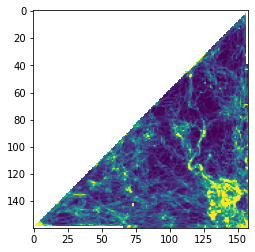

In [21]:
from rasterio.plot import show
import rioxarray
p = show(xr_steps_10m, vmin=xr_steps_10m.quantile(0.025), vmax=xr_steps_10m.quantile(0.975))
xr_steps_10m = xr_steps_10m.rio.set_crs('EPSG:32613')
xr_steps_10m.rio.to_raster('C:/Users/sean.kearney/OneDrive - USDA/Desktop/test_10m.tif')
xr_steps_1m = xr_steps_1m.rio.set_crs('EPSG:32613')
xr_steps_1m.rio.to_raster('C:/Users/sean.kearney/OneDrive - USDA/Desktop/test_1m.tif')
xr_steps_30m = xr_steps_1m.coarsen(dim=dict(x=30, y=30), 
                                   boundary='trim').sum()
xr_steps_30m.rio.to_raster('C:/Users/sean.kearney/OneDrive - USDA/Desktop/test_30m.tif')

#show(past_mask_10m)

In [20]:
past

'20SE'

In [199]:
xr_temp_30m = past_mask_30m.where(past_mask_30m == past, drop=True)
xr_temp_30m = xr_temp_30m.assign_attrs({'transform': (30.0, 0.0, xr_temp_30m.x.min().values - 15.0, 
                                           0.0, -30.0, xr_temp_30m.y.max().values + 15.0)})

xr_interp_temp = xr_temp_30m.to_dataset(name='temp')
xr_interp_temp = xr_interp_temp.assign(x_30m = xr_interp_temp.x)
xr_interp_temp = xr_interp_temp.assign(y_30m = xr_interp_temp.y)
xr_interp_temp = xr_interp_temp.interp_like(xr_steps_1m, method='nearest')
xr_interp_temp= xr_interp_temp.assign(gi=xr_steps_1m)#.groupby(['x_30m', 'y_30m']).sum()

xr_steps_30m = xr_interp_temp.set_coords(['x_30m', 'y_30m']).swap_dims(
    {'x': 'x_30m',
     'y': 'y_30m'}).stack(
    points=['x_30m', 'y_30m']).groupby('points').sum().unstack().rename(
    {'points_level_0': 'x', 'points_level_1': 'y'}).transpose().sortby(
    'y', ascending=False)['gi'].where(xr_temp_30m == past)

df_tmp = pd.DataFrame({
    'Pasture': past,
    'UTM_X': [i[0] for i in xr_steps_30m.stack(z=['x', 'y'])['z'].values],
    'UTM_Y': [i[1] for i in xr_steps_30m.stack(z=['x', 'y'])['z'].values],
    'grazing_secs': xr_steps_30m.stack(z=['x', 'y']).values
})

# Loop through static and time series co-variates and extract for each grid cell
target_lon = xr.DataArray(df_tmp['UTM_X'], dims="points")
target_lat = xr.DataArray(df_tmp['UTM_Y'], dims="points")
# loop through static covariates and get values
for var in static_covariates:
    xr_tmp = static_covariates[var]['data']
    df_tmp.loc[:, var] = xr_tmp.sel(
        x=target_lon, y=target_lat, method='nearest').values

# get distance to pasture corners
gdf_corners_p = gdf_corners[gdf_corners['Pasture'] == past]
x_coords = [i[0][0] for i in gdf_corners_p.apply(lambda x: x.geometry.coords.xy, axis=1)]
y_coords = [i[1][0] for i in gdf_corners_p.apply(lambda x: x.geometry.coords.xy, axis=1)]

# Create a BallTree object
# borrowed from: https://stackoverflow.com/questions/58893719/find-nearest-point-in-other-dataframe-with-a-lot-of-data
tree = BallTree(np.array(list(zip(x_coords, y_coords))), leaf_size=2)

#Query the BallTree on all GPS coordinates from collars deployed in the pasture to find the distance
# to the nearest pixel within the pasture and its id
dist_tmp, id_tmp= tree.query(
    df_tmp.loc[:, ['UTM_X', 'UTM_Y']].values, # The input array for the query
    k=1, # The number of nearest neighbors
)
df_tmp.loc[:, 'dCorner'] = dist_tmp

df_tmp['grazing_secs'][df_tmp['grazing_secs'] > 3.40e38] = np.nan
df_tmp = df_tmp[df_tmp['grazing_secs'].notnull()]

  0%|          | 0/193 [00:00<?, ?it/s]

C:\Users\sean.kearney\Github\lotek_processing\lotek\gps.py:24: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
C:\Users\sean.kearney\Github\lotek_processing\lotek\gps.py:23: RuntimeWarning: invalid value encountered in double_scalars
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WAR

In [211]:
import pyproj
geodesic = pyproj.Geod(ellps='WGS84')
utm_13N = pyproj.Proj(32613)

In [213]:
steps_coords.iloc[0][0][0]

121.28412260636215

In [215]:
utm_13N.get_factors(steps_coords.iloc[0][0][0], steps_coords.iloc[0][1][0]).meri

Factors(meridional_scale=1.1233158408418584, parallel_scale=1.1233158408961128, areal_scale=1.2618384783471965, angular_distortion=0.0, meridian_parallel_angle=90.0, meridian_convergence=140.92685611802986, tissot_semimajor=1.1233158408689858, tissot_semiminor=1.1233158408689858, dx_dlam=-0.5514251371088741, dx_dphi=-0.7075710476769913, dy_dlam=0.4477020439042078, dy_dphi=-0.8715002917769609)

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


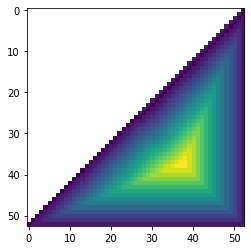

<AxesSubplot:>

In [207]:
from rasterio.plot import show
show(static_covariates['dFence']['data'].where(xr_temp_30m == past).data)

In [209]:
static_covariates['dFence']['data'].where(xr_temp_30m == past).rio.to_raster(
    'C:/Users/sean.kearney/OneDrive - USDA/Desktop/dFence.tif')

AttributeError: 'DataArray' object has no attribute 'rio'

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


In [135]:
import pyproj
geodesic = pyproj.Geod(ellps='WGS84')
utm_13N = pyproj.Proj(32613)
#coords = utm_13N(gdf_steps.geometry.iloc[0].coords.xy, inverse=True)
#utm_13N(coords[0], coords[1], inverse=True)
#fwd_azimuth,back_azimuth,distance = geodesic.inv(test.iloc[loc][0][0], test.iloc[loc][1][0], 
#                                                 test.iloc[loc][0][1], test.iloc[loc][1][1])

fwd_azimuth_all = test.apply(lambda x: geodesic.inv(x[0][0], x[1][0], x[0][1], x[1][1])[0])
distance_all = test.apply(lambda x: geodesic.inv(x[0][0], x[1][0], x[0][1], x[1][1])[2])

In [ ]:
#45, 135, 225, 305

In [112]:
10/np.sqrt(2)

7.071067811865475

In [113]:
import math

In [171]:
10*math.cos(math.radians(20))

9.396926207859085

In [136]:
#distance
df_test = pd.DataFrame({
    'distance': distance_all,
    'bearing': fwd_azimuth_all,
    'diff45': abs(round(abs(fwd_azimuth_all/90)) - abs(fwd_azimuth_all/90)) * 2.0})#.iloc[0]

In [139]:
#df_test

In [146]:
df_test['cell_ct'] = df_test.apply(lambda x: np.ceil(x.distance*math.cos(math.radians(45*x.diff45))), axis=1)

In [177]:
df_test['steplength'] = gdf_steps['steplength']

In [178]:
df_test

,distance,bearing,diff45,cell_ct,steplength
23,1.045898,23.210432,0.515787,1.0,1.077888
41,2.320634,-35.466551,0.788146,2.0,2.391614
42,0.924548,19.426692,0.431704,1.0,0.952826
45,0.449381,-60.046999,0.665622,1.0,0.463126
64,14.076393,-113.910858,0.531352,13.0,14.506937
...,...,...,...,...,...
34050,22.707688,-77.342101,0.281287,23.0,23.401788
34051,8.722344,-86.801393,0.071080,9.0,8.988959
34052,8.013864,-135.107288,0.997616,6.0,8.258821
34056,18.935455,-128.917949,0.864843,15.0,19.514232


In [200]:
gdf_steps.Fix_Duration[gdf_steps['GrazingAct'] == 1].sum()/60/24

74.75347222222221

In [ ]:
from rasterio.plot import show
show(xr_steps_30m.rio.set_crs('EPSG: 32613'))

In [202]:
xr_steps_30m.sum()/60/60/24

<xarray.DataArray 'gi' ()>
array(68.21093171)

In [201]:
xr_steps_1m.sum()/60/60/24

<xarray.DataArray ()>
array(75.16538194)

In [188]:
df_tmp.grazing_secs.sum()/60/60/24

70.10081018518518

In [189]:
df_gps['Fix_Duration'][df_gps['GrazingAct'] == 1].sum()/60/24

74.84722222222221

In [150]:
xr_steps_30m.sum()/60/60/24

<xarray.DataArray 'gi' ()>
array(41.77118634)

In [151]:
xr_steps_1m.sum()/60/60/24

<xarray.DataArray ()>
array(42.77841146)

In [194]:
df_tmp['dFence'][df_tmp['dFence'] > 30]#.grazing_secs.sum()/60/60/24

210     42
262     42
263     60
314     42
315     67
        ..
2750    60
2751    60
2752    60
2753    60
2754    60
Name: dFence, Length: 1200, dtype: int16

In [153]:
df_gps['Fix_Duration'][df_gps['GrazingAct'] == 1].sum()/60/24

44.75694444444445

In [317]:
xr_steps_30m.rio.set_crs('EPSG: 32613').rio.to_raster('C:/Users/sean.kearney/OneDrive - USDA/Desktop/test_7SE_v2.tif')

In [318]:
xr_steps_1m.rio.set_crs('EPSG: 32613').rio.to_raster('C:/Users/sean.kearney/OneDrive - USDA/Desktop/test_7SE_1m_v2.tif')

In [321]:
#df_tmp['grazing_secs'][df_tmp['dFence'] < 15].sum()/60/60/24

2.578464445891204

In [307]:
df_gps.to_csv('C:/Users/sean.kearney/OneDrive - USDA/Desktop/gps_7SE_test.csv')

In [225]:
carm_list = glob.glob(outDIR + 'CARM*.csv')
trm_list = glob.glob(outDIR + 'TRM*.csv')

In [229]:
import matplotlib.pyplot as plt
#bins = np.concatenate([np.arange(0, 4.25, 0.25), np.array([100000])])
bins_std = np.arange(0, 4.25, 0.25)
for carm_f in carm_list:
    print(carm_f)
    df_carm = pd.read_csv(carm_f)
    df_carm.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_carm = df_carm[(df_carm['dCorner'] > 50) & (df_carm['dTank'] > 50)]
    df_carm['grazing_secs_stnd'] = df_carm['grazing_secs'] / df_carm['grazing_secs'].mean()
    df_carm.loc[df_carm['grazing_secs_stnd'] > 4.0, 'grazing_secs_stnd'] = 4.0
    carm_prefix = '_'.join(carm_f.split('\\')[-1].split('_')[0:2])
    trm_prefix = re.sub('CARM', 'TRM', carm_prefix)
    if 'd_graze_intens_grid.csv' in carm_f:
        #bins = np.arange(0, 20000, 100)
        trm_sub = [x for x in trm_list if trm_prefix in x and 'd_graze_intens_grid.csv' in x]
        if len(trm_sub) == 1:
            trm_f = trm_sub[0]
        else:
            print('Error: multiple or no files found for TRM')
    else:
        #bins = np.arange(0, 5000, 100)
        trm_sub = [x for x in trm_list if trm_prefix in x and 'd_graze_intens_grid.csv' not in x]
        if len(trm_sub) == 1:
            trm_f = trm_sub[0]
        else:
            print('Error: multiple or no files found for TRM')
    print(trm_f)
    df_trm = pd.read_csv(trm_f)
    df_trm.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_trm = df_trm[(df_trm['dCorner'] > 50) & (df_trm['dTank'] > 50)]
    df_trm['grazing_secs_stnd'] = df_trm['grazing_secs'] / df_trm['grazing_secs'].mean()
    df_trm.loc[df_trm['grazing_secs_stnd'] > 4.0, 'grazing_secs_stnd'] = 4.0
    plt.figure()
    ax = df_trm.hist('grazing_secs_stnd', bins=bins_std, alpha=0.6)
    df_carm.hist('grazing_secs_stnd', bins=bins_std, ax=ax, alpha=0.6)
    plt.savefig(outDIR + 'hist_plots_stnd/' + re.sub('_graze_intens_grid.csv', '_hist_stnd.png', carm_f.split('\\')[-1]))
    plt.close()
    
    ax2 = df_trm.hist('grazing_secs', alpha=0.6)
    df_carm.hist('grazing_secs', ax=ax2, alpha=0.6)
    plt.savefig(outDIR + 'hist_plots/' + re.sub('_graze_intens_grid.csv', '_hist.png', carm_f.split('\\')[-1]))
    plt.close()
    
    

C:/SPK_local/for_others/Augustine_lotek/paired_comps\CARM2014_Rotn1_10steer_125d_graze_intens_grid.csv
C:/SPK_local/for_others/Augustine_lotek/paired_comps\TRM2014_Rotn1_1steer_125d_graze_intens_grid.csv
C:/SPK_local/for_others/Augustine_lotek/paired_comps\CARM2014_Rotn1_2steers_graze_intens_grid.csv
C:/SPK_local/for_others/Augustine_lotek/paired_comps\TRM2014_Rotn1_2steers_graze_intens_grid.csv
C:/SPK_local/for_others/Augustine_lotek/paired_comps\CARM2014_Rotn2_1steer_graze_intens_grid.csv
C:/SPK_local/for_others/Augustine_lotek/paired_comps\TRM2014_Rotn2_1steer_graze_intens_grid.csv
C:/SPK_local/for_others/Augustine_lotek/paired_comps\CARM2014_Rotn2_7steer_124d_graze_intens_grid.csv
C:/SPK_local/for_others/Augustine_lotek/paired_comps\TRM2014_Rotn2_1steer_124d_graze_intens_grid.csv
C:/SPK_local/for_others/Augustine_lotek/paired_comps\CARM2014_Rotn3_10steers_119d_graze_intens_grid.csv
C:/SPK_local/for_others/Augustine_lotek/paired_comps\TRM2014_Rotn3_1steer_119d_graze_intens_grid.csv


C:\Users\SEAN~1.KEA\AppData\Local\Temp/ipykernel_17308/4148696572.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


C:/SPK_local/for_others/Augustine_lotek/paired_comps\CARM2017_Rotn3_8steer_132d_graze_intens_grid.csv
C:/SPK_local/for_others/Augustine_lotek/paired_comps\TRM2017_Rotn3_1steer_132d_graze_intens_grid.csv
C:/SPK_local/for_others/Augustine_lotek/paired_comps\CARM2018_Rotn1_2steer_graze_intens_grid.csv
C:/SPK_local/for_others/Augustine_lotek/paired_comps\TRM2018_Rotn1_2steer_graze_intens_grid.csv
C:/SPK_local/for_others/Augustine_lotek/paired_comps\CARM2018_Rotn1_9steer_101d_graze_intens_grid.csv
C:/SPK_local/for_others/Augustine_lotek/paired_comps\TRM2018_Rotn1_1steer_101d_graze_intens_grid.csv
C:/SPK_local/for_others/Augustine_lotek/paired_comps\CARM2018_Rotn2_9steer_125d_graze_intens_grid.csv
C:/SPK_local/for_others/Augustine_lotek/paired_comps\TRM2018_Rotn2_2steer_125d_graze_intens_grid.csv
C:/SPK_local/for_others/Augustine_lotek/paired_comps\CARM2018_Rotn3_2steer_graze_intens_grid.csv
C:/SPK_local/for_others/Augustine_lotek/paired_comps\TRM2018_Rotn3_2steer_graze_intens_grid.csv
C:/SP

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [51]:
re.sub('_graze_intens_grid.csv', 'hist.png', glob.glob(outDIR + 'TRM*.csv')[0].split('\\')[-1])

'TRM2014_Rotn1_1steer_125dhist.png'

array([[<AxesSubplot:title={'center':'grazing_secs'}>]], dtype=object)

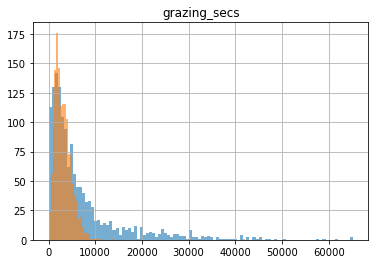

In [45]:
ax = df_trm.hist('grazing_secs', bins=100, alpha=0.6)
df_carm.hist('grazing_secs', bins=100, ax=ax, alpha=0.6)

In [202]:
#zip the coordinates into a point object and convert to a GeoData Frame
geometry = [Point(xy) for xy in zip(df_gps.UTM_X[(df_gps.bout_act == 'Grazing') & 
                                                 df_gps.moverate.notnull()],
                                    df_gps.UTM_Y[(df_gps.bout_act == 'Grazing') &
                                                 df_gps.moverate.notnull()])]
if len(geometry) == 0:
    print("    SKIPPING STEER: All points masked.")
else:
    gdf_pts = gpd.GeoDataFrame(df_gps[(df_gps.bout_act == 'Grazing') & df_gps.moverate.notnull()],
                               geometry=geometry)

    # create lines for each grazing bout, grouped by each steer and date
    gdf_bouts = gdf_pts.groupby(['Steer_ID', 'SliceDay', 
                                 'grazing_bout'])['geometry'].apply(lambda x: LineString(x.tolist()))
    gdf_bouts = gpd.GeoDataFrame(gdf_bouts, geometry='geometry').reset_index(drop=False)

# calculate movement rate of each step
secs_m = gdf_pts.groupby(['Steer_ID', 'SliceDay',
                 'grazing_bout'])['moverate'].apply(lambda x: 60/x.shift(-1))

# drop null values created after last step
secs_m = secs_m[~np.isnan(secs_m)]

# create geodata frame of steps
gdf_steps = gdf_bouts.copy(deep=True)
gdf_steps['geometry'] = gdf_bouts.apply(lambda x: GeometryCollection(segments(x.geometry)), axis=1)
gdf_steps = gpd.GeoDataFrame(gdf_steps, geometry='geometry').reset_index(drop=False)
gdf_steps = gdf_steps.explode()

# add movement rate to geodata frame
gdf_steps['secs_m'] = secs_m.values

In [207]:
df_gps#.columns

,Date_Time,Fix,Latitude,Longitude,Altitude,Temp,DOP,X_act,Y_act,Head_Down,...,Tag,Deployment,Year,Pasture,UTM_X,UTM_Y,Fix_Duration,steplength,turnangle,moverate
0,2015-05-16 00:00:00,180,40.832484,-104.705635,1619.758,15.0,2.6,0,1,97.3,...,927,D1,2015,18S,524819.1359,4520203.177,NaN,NaN,NaN,NaN
1,2015-05-16 00:05:00,181,40.832404,-104.705588,1624.453,15.0,2.6,28,82,82.7,...,927,D1,2015,18S,524823.1034,4520194.243,5.0,9.775347,118.276575,1.955069
2,2015-05-16 00:10:00,182,40.832542,-104.705446,1622.887,14.5,2.6,42,15,91.3,...,927,D1,2015,18S,524835.0161,4520209.613,5.0,19.446062,29.230755,3.889212
3,2015-05-16 00:15:00,183,40.832908,-104.705372,1622.238,13.0,2.1,12,0,100.0,...,927,D1,2015,18S,524841.1354,4520250.329,5.0,41.173274,45.301344,8.234655
4,2015-05-16 00:20:00,184,40.833154,-104.705613,1620.395,12.0,1.9,8,0,100.0,...,927,D1,2015,18S,524820.7830,4520277.580,5.0,34.012309,89.611183,6.802462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28164,2015-05-26 23:35:00,3356,40.829995,-104.713093,1620.000,16.5,1.7,0,6,0.7,...,33,D1,2015,18S,524191.1994,4519924.807,5.0,0.504186,172.178642,0.100837
28165,2015-05-26 23:40:00,3357,40.829997,-104.713070,1618.172,16.5,1.7,0,0,0.0,...,33,D1,2015,18S,524193.1380,4519925.025,5.0,1.950819,166.805381,0.390164
28166,2015-05-26 23:45:00,3358,40.829996,-104.713073,1619.840,16.5,1.7,2,10,33.3,...,33,D1,2015,18S,524192.8854,4519924.935,5.0,0.268154,57.045403,0.053631
28167,2015-05-26 23:50:00,3359,40.829982,-104.713078,1619.617,16.5,1.7,0,16,0.7,...,33,D1,2015,18S,524192.5111,4519923.357,5.0,1.621784,148.232048,0.324357


In [208]:
gps_f

'T:/5-CattleCollars/3-Projects/CARM_PairedComps/Paired Comps Long\\CARM2015_Rotn1_9steer_98d.csv'

In [188]:
18874-17779

1095

In [190]:
# calculate movement rate of each step
secs_m = gdf_pts.groupby(['Steer_ID', 'SliceDay',
                 'grazing_bout'])['moverate'].apply(lambda x: 60/x.shift(-1))


In [193]:
secs_m.isnull().sum()

1097

In [201]:
gdf_pts['moverate'].isnull().sum()

3

In [ ]:
"""
Old script that 'snaps' to Landsat
"""
gps_f = test_f
try:
    df_gps = pd.read_csv(gps_f, engine='python', parse_dates=['Date_Time'])
except ValueError:
    df_gps = pd.read_csv(gps_f, engine='python', parse_dates=['Date_Time_Fix'])
    df_gps['Date_Time'] = df_gps['Date_Time_Fix']

df_gps['Fix_Duration'] = df_gps.groupby(['Steer_ID', 'SliceDay']).apply(
lambda x: (x['Date_Time'] - x['Date_Time'].shift(1)).dt.seconds/60.0).reset_index()['Date_Time']

# calculate the turning angle and distance at each fix for each day and each steer
df_gps['steplength'] = np.nan
df_gps['turnangle'] = np.nan
for group in tqdm(df_gps.groupby(['Steer_ID', 'SliceDay'])):
    group[1]['UTM_X_lag1'] = group[1]['UTM_X'].shift(1)
    group[1]['UTM_Y_lag1'] = group[1]['UTM_Y'].shift(1)
    group[1]['UTM_X_lead1'] = group[1]['UTM_X'].shift(-1)
    group[1]['UTM_Y_lead1'] = group[1]['UTM_Y'].shift(-1)
    a_list = list(group[1][['UTM_X_lag1', 'UTM_Y_lag1']].values)
    b_list = list(group[1][['UTM_X', 'UTM_Y']].values)
    c_list = list(group[1][['UTM_X_lead1', 'UTM_Y_lead1']].values)
    dist_mask = ~(np.any(np.isnan(a_list), axis=1) |  np.any(np.isnan(b_list), axis=1))
    sl_tmp = np.ones_like(dist_mask) * np.nan
    sl_tmp[dist_mask] = calc_dist(np.array(list(map(tuple, a_list)))[dist_mask], 
                                  np.array(list(map(tuple, b_list)))[dist_mask]).squeeze()
    df_gps.loc[(df_gps['Steer_ID'] == group[0][0]) & (df_gps['SliceDay'] == group[0][1]),
               'steplength'] = sl_tmp
    df_gps.loc[(df_gps['Steer_ID'] == group[0][0]) & (df_gps['SliceDay'] == group[0][1]),
               'turnangle'] = calc_ta(a_list, b_list, c_list)
    df_gps.loc[(df_gps['Steer_ID'] == group[0][0]) & (df_gps['SliceDay'] == group[0][1]),
               'UTM_X_lag1'] = group[1]['UTM_X_lag1']
    df_gps.loc[(df_gps['Steer_ID'] == group[0][0]) & (df_gps['SliceDay'] == group[0][1]),
               'UTM_Y_lag1'] = group[1]['UTM_Y_lag1']
    

# Calculate movement rate from distance and timestamp
df_gps['moverate'] = df_gps['steplength'] / df_gps['Fix_Duration']

# create activity bouts
df_gps['grazing_bout'] = df_gps.groupby(['SliceDay', 'Steer_ID'])['GrazingAct'].apply(
    lambda x: (((x != x.shift(1)) &
                ((x == x.shift(-1)) | (x == x.shift(-2))) & 
                ((x != x.shift(2)) | (x != x.shift(3))))).cumsum())
# calculate duration of each bout in minutes
df_gps['bout_mins'] = df_gps.groupby(['SliceDay', 'Steer_ID', 'grazing_bout'])['Date_Time'].transform(lambda x: (x.max() - x.min()).seconds/60 + 5.0)

# calculate the majority grazing activity for each bout to calculate bout activity
df_gps['bout_maj'] = df_gps.groupby(['SliceDay', 'Steer_ID', 'grazing_bout'])['GrazingAct'].transform(lambda x: x.value_counts().index[0])

# create a bout activity column
bout_act_dict = {0: 'Nongrazing',
                1: 'Grazing'}
df_gps['bout_act'] = df_gps['bout_maj'].apply(lambda x: bout_act_dict[x])
df_gps.loc[df_gps['bout_mins'] < 20, 'bout_act'] = 'Transition'

geometry_steps = df_gps[(df_gps.GrazingAct == 1) &
                        df_gps.moverate.notnull()].apply(make_steps, axis=1)

gdf_steps = gpd.GeoDataFrame(df_gps[(df_gps.GrazingAct == 1) &
                                    df_gps.moverate.notnull()],
                             geometry=geometry_steps)

steps_coords = gdf_steps.apply(lambda x: utm_13N(x.geometry.coords.xy[0],
                                                 x.geometry.coords.xy[1], 
                                                 inverse=True), axis=1)

fwd_azimuth_all = steps_coords.apply(lambda x: geodesic.inv(x[0][0],
                                                            x[1][0],
                                                            x[0][1],
                                                            x[1][1])[0])

gdf_steps['bearing'] = fwd_azimuth_all
gdf_steps['diff45'] = abs(round(abs(fwd_azimuth_all/90)) - abs(fwd_azimuth_all/90)) * 2.0
gdf_steps['cell_ct'] = gdf_steps.apply(lambda x: 1 + np.round(x.steplength*math.cos(math.radians(45*x.diff45))), 
                                       axis=1)


secs_m = gdf_steps.apply(graze_intensity, axis=1)

# add movement rate to geodata frame
gdf_steps['secs_m'] = secs_m.values

past = df_gps['Pasture'].unique()[0]
xr_temp_1m = past_mask_1m.where(past_mask_1m == past, drop=True)
xr_temp_1m = xr_temp_1m.assign_attrs({'transform': (1.0, 0.0, xr_temp_1m.x.min().values - 0.5, 
                                           0.0, -1.0, xr_temp_1m.y.max().values + 0.5)})
steps_info = gdf_steps[['secs_m', 'geometry']].reset_index(drop=True).reset_index().rename(
    columns={'index': 'id'})
steps_shp = [(row.geometry, row.secs_m) for _, row in steps_info.iterrows()]
xr_steps_1m = shp2mask(shp=steps_shp, xr_object=xr_temp_1m, dtype='float32',
                    merge_alg=MergeAlg('ADD'), all_touched=False)#.stack(z=['x', 'y'])
xr_temp_30m = past_mask_30m.where(past_mask_30m == past, drop=True)
xr_temp_30m = xr_temp_30m.assign_attrs({'transform': (30.0, 0.0, xr_temp_30m.x.min().values - 15.0, 
                                           0.0, -30.0, xr_temp_30m.y.max().values + 15.0)})

xr_interp_temp = xr_temp_30m.to_dataset(name='temp')
xr_interp_temp = xr_interp_temp.assign(x_30m = xr_interp_temp.x)
xr_interp_temp = xr_interp_temp.assign(y_30m = xr_interp_temp.y)
xr_interp_temp = xr_interp_temp.interp_like(xr_steps_1m, method='nearest')
xr_interp_temp= xr_interp_temp.assign(gi=xr_steps_1m)#.groupby(['x_30m', 'y_30m']).sum()

xr_steps_30m = xr_interp_temp.set_coords(['x_30m', 'y_30m']).swap_dims(
    {'x': 'x_30m',
     'y': 'y_30m'}).stack(
    points=['x_30m', 'y_30m']).groupby('points').sum().unstack().rename(
    {'points_level_0': 'x', 'points_level_1': 'y'}).transpose().sortby(
    'y', ascending=False)['gi'].where(xr_temp_30m == past)

df_tmp = pd.DataFrame({
    'Pasture': past,
    'UTM_X': [i[0] for i in xr_steps_30m.stack(z=['x', 'y'])['z'].values],
    'UTM_Y': [i[1] for i in xr_steps_30m.stack(z=['x', 'y'])['z'].values],
    'grazing_secs': xr_steps_30m.stack(z=['x', 'y']).values
})

# Loop through static and time series co-variates and extract for each grid cell
target_lon = xr.DataArray(df_tmp['UTM_X'], dims="points")
target_lat = xr.DataArray(df_tmp['UTM_Y'], dims="points")
# loop through static covariates and get values
for var in static_covariates:
    xr_tmp = static_covariates[var]['data']
    df_tmp.loc[:, var] = xr_tmp.sel(
        x=target_lon, y=target_lat, method='nearest').values

# get distance to pasture corners
gdf_corners_p = gdf_corners[gdf_corners['Pasture'] == past]
x_coords = [i[0][0] for i in gdf_corners_p.apply(lambda x: x.geometry.coords.xy, axis=1)]
y_coords = [i[1][0] for i in gdf_corners_p.apply(lambda x: x.geometry.coords.xy, axis=1)]

# Create a BallTree object
# borrowed from: https://stackoverflow.com/questions/58893719/find-nearest-point-in-other-dataframe-with-a-lot-of-data
tree = BallTree(np.array(list(zip(x_coords, y_coords))), leaf_size=2)

#Query the BallTree on all GPS coordinates from collars deployed in the pasture to find the distance
# to the nearest pixel within the pasture and its id
dist_tmp, id_tmp= tree.query(
    df_tmp.loc[:, ['UTM_X', 'UTM_Y']].values, # The input array for the query
    k=1, # The number of nearest neighbors
)
df_tmp.loc[:, 'dCorner'] = dist_tmp

df_tmp['grazing_secs'][df_tmp['grazing_secs'] > 3.40e38] = np.nan
df_tmp = df_tmp[df_tmp['grazing_secs'].notnull()]